# **Number detection algorithm**

## **Introduction**

This is the main program that makes different methods of number classification 

## **Image Traitement**

Before using the ML algorithm it must verify that the images that will be used in the classification is in the same format and size as the ones in the database (MNIST)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2 as cv
from scipy import ndimage
import os

In [47]:
# This function is responsable to open all the images obtained by the camera and already processed. 
# The images are transform to be able to compare with the EMNIST database. To do so, basically,
# the function bellow identiify the number in the image, remove this number, insert it in a new image
# in the format of the database and create a file test.cvs to be use by the machine learning's algorithms. 

def image_traitement(image_path):

    # set the parameters to read the images
    image_path_chiffre = image_path # path of the file
    chiffre = image_path_chiffre[-2] # number of the dice

    # list to store all the images in the folder
    image_list = []
    for x in os.listdir(image_path_chiffre):
        path_image = image_path_chiffre + x
        im = cv.imread(path_image, 0)
        image_list.append(im)

    # list with images after the processing
    resized_list = []

    # image processing for each image of the folder
    for im in image_list:

        # convert the color to gray
        imgray = cv.cvtColor(im, cv.COLOR_GRAY2BGR) #for better accuracy, use binary images
        
        # apply the threshold to invert the pixels of the image
        # all pixels value equal to 255 (white) will be set to 0 (black)
        ret, thresh = cv.threshold(im, 225, 255, cv.THRESH_BINARY_INV) #OBS: try change to imgray
        #plt.imshow(im, cmap='gray') # image with the pixels inverted
        
        # calculate all the countors of the image
        # the variable contours contains points of the countors
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        # loop over the contours points, calculate the area of these points and 
        # chose the first area that is sufficently large
        for i in range(len(contours)):

            # calcul de la zone des contours
            area = cv.contourArea(contours[i])

            # if the contour is sufficiently large, it must be the digit
            if area > 50 and area < 700:
                
                # compute the bounding box where (x,y) is the top-left coordinate of the rectangle 
                # and (w,h) is the width and height
                (x, y, w, h) = cv.boundingRect(contours[i]) # calcul de coordonnes de la zone

                # affiche les rectangles sur l'image binaire
                #cv.rectangle(imgray, (x,y), (x+w,y+h), (255,255,0), 2) 

                # extract the region of interest (ROI) using the informations of the bounding box
                diceROI = thresh[y-2 : y+h+2, x-2 : x+w+2] # extraction de la zone sur l'image    
                #plt.matshow(diceROI, cmap="gray")
                break
                 
        # calculate the center of mass, the height and the width of the ROI
        centre_h, centre_w = ndimage.measurements.center_of_mass(diceROI)
        h, w = diceROI.shape
        
        # create a new image and insert the ROI
        n = 56 # the ROI will be insert in the center of a bigger image
        
        black_image = np.zeros((n,n))
        black_image[int((n-h)/2) : int(((n-h)/2)+h), int((n-w)/2) : int(((n-w)/2)+w)] = diceROI 
        #plt.matshow(black_image, cmap='gray')

        # resize the image to the format 28x28 pixel (format of the database)
        scale_percent = 50 # percent of original size
        
        width = int(black_image.shape[1] * scale_percent / 100)
        height = int(black_image.shape[0] * scale_percent / 100)
        dim = (width, height)

        # resize the image
        resized = cv.resize(black_image, dim, interpolation = cv.INTER_AREA)
        resized_list.append(resized) # add to the list of final images

        # write the pixel matrix in the test.csv file, the row will have 785 columns (28x28 + 1)
        # where the last column is the dice's number
        A = np.asarray(resized).reshape(-1) # shape the matrix to just one line
        
        row = []
        for result in A:
            row.append(result)
        row.append(float(chiffre)) #the last column is the dice's number

        # open the file in the for appending new information (new row)
        with open('test.csv', "a") as file:
            writer = csv.writer(file)
            writer.writerow(row) 

    # print the processed images 
    #print("Dice's number: " + str(chiffre))
    #print("Number of the images in the folder: " + str(len(image_list)))
    #print("Number of the images created: " + str(len(resized_list)))
    #for pos in range(0, len(resized_list)):
    #    plt.matshow(resized_list[pos], cmap='gray')
    '''
    if os.path.isfile('test.csv'):
        print ("END")
    else:
        print ('file does not exist')
    '''

## **Machine Learning Algorithm**

This part contains the ML algorithm with different classifiers, firt there are some functions declarations that are used to manipulate the files in the folder.

In [48]:
from keras.datasets import mnist
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score


In [49]:
#Extract the numbers from database

def selectDiceNumbers(img_list_all, labels_list_all):
    img_final = []
    labels_final = []
    diceNumbers = [1, 2, 3, 4, 5, 6]

    if len(img_list_all) == len(labels_list_all):
        initialSize = range(len(img_list_all))
    else:
        print("Size of lists must be the same!")

    for i in initialSize:
        if (labels_list_all[i] in diceNumbers):
            img_final.append(img_list_all[i])
            labels_final.append(labels_list_all[i])
    
    return img_final, labels_final

def load_datasets():
    print("Loading Training dataset and Testing dataset...")
    (img_train_all, labels_train_all),(img_test_all, labels_test_all) = mnist.load_data()
    
    img_train, labels_train = selectDiceNumbers(img_train_all, labels_train_all)
    img_test, labels_test = selectDiceNumbers(img_test_all, labels_test_all)

    print("Finished loading!")
    
    return img_train, labels_train, img_test, labels_test

    
X_train, Y_train, X_test, Y_test = load_datasets()
#Train dataset size = 36012
#Test dataset size = 6009

Loading Training dataset and Testing dataset...
Finished loading!


In [50]:
def read_test():    
    image = []
    labels = []
    with open('test.csv', 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
        for line in spamreader:
            image.append(np.array(line[:-1]))
            labels.append(line[-1])
    
    return image, labels

In [51]:
def create_number_list(data):
    images = []
    for x in data:
        number = []
        for y in x:
            for pixel in y:
                number.append(pixel)
        images.append(number)

    return images

def test(clf, n):
    # Train on the first n images:
    train_x = create_number_list(X_train[:n])
    train_y = np.array(Y_train[:n])

    # Test on the next n/6 images:
    test_x = create_number_list(X_test[:n/6])
    test_y = np.array(Y_test[:n/6]) 

    clf.fit(train_x, train_y)

    img_test2, labels_test2 = read_test()
    
    # Test on the next n/6 images:
    test_x = img_test2[0:len(img_test2)]
    expected = [int(i) for i in labels_test2[0:len(labels_test2)]]

    predicted = clf.predict(test_x)

    print("The accuracy is: " + str(accuracy_score(expected, predicted)))
    
    correct = 0
    for i in range(len(expected)):
        if expected[i] == predicted[i]:
            correct += 1
            pass
        else:
            print("Expected: " + str(expected[i]) + ",Predicted: " + str(predicted[i]))
    
    print("Correct classification:" + str(correct) + "/" + str(len(predicted)))
    
    


In [52]:
def DecisionTree():
    print("Decision Tree model")
    clf = DecisionTreeClassifier(random_state = 0, max_depth = 5)

    test(clf, 10000)
    
def KK():
    print("KK neighbors model")
    clf = KNeighborsClassifier(n_neighbors = 1)

    test(clf, 10000)

def RandomForest():
    print("Random Forest model")
    clf = RandomForestClassifier(n_estimators=100)

    test(clf, 10000)
    
def SVM():
    print("SVM model")
    clf = svm.LinearSVC(random_state=0)

    test(clf, 10000)

In [53]:
import os
import sys

def main(model, append, fig):
    
    valid_models = [1, 2, 3, 4]
    valid_numbers = [0, 1, 2, 3, 4, 5, 6]

    if model not in valid_models:
        print("MODEL VALUE MUST BE 1,2,3,4")
        sys.exit()
    
    if fig not in valid_numbers:
        print("FACE MUST BE 0,1,2,3,4,5,6")
        sys.exit()
        
    if append != 0 and append != 1:
        print("APPEND MUST BE 0 OR 1")
        sys.exit()

    img1 = os.getcwd() + '/chiffres/Numero1/'
    img2 = os.getcwd() + '/chiffres/Numero2/'
    img3 = os.getcwd() + '/chiffres/Numero3/'
    img4 = os.getcwd() + '/chiffres/Numero4/'
    img5 = os.getcwd() + '/chiffres/Numero5/'
    img6 = os.getcwd() + '/chiffres/Numero6/'        
        
    if fig == 0 or append ==1:
        img = [img1, img2, img3, img4, img5, img6]
    elif fig == 1:
        img = img1
    elif fig == 2:
        img = img2
    elif fig == 3:
        img = img3
    elif fig == 4:
        img = img4
    elif fig == 5:
        img = img5
    elif fig == 6:
        img = img6

    if os.path.isfile('test.csv'):
        os.remove('test.csv')
    else:
        print 'Test file does not exist'
            
    if append == 0:
        image_traitement(img)
    elif append == 1:
        for image in img:
            image_traitement(image)

    if os.path.isfile('test.csv'):
        print "Created test file"

    else:
        print 'Test file does not exist'

    if model == 1:
        DecisionTree()
    elif model == 2:
        KK()
    elif model == 3:
        RandomForest()
    elif model == 4:
        SVM()

In [54]:
# Fist argument is the model (1 to 4 models)
# 1 ==> Decision Tree Classifier
# 2 ==> KK neighbors Classifier
# 3 ==> Random Forest Classifier
# 4 ==> SVM Classifier

# Second argument is the image append (0,1)
# If it is 0 the third argument is the number the algorithm will analyse
# If it is 1 the algorithm will analyse all numbers

# Third argument is the number to analyse(0 to 6)
# If it is 0 the algorithm will analyse all numbers
main(3, 1, 1)

Created test file
Random Forest model
The accuracy is: 0.447368421053
Expected: 1,Predicted: 2
Expected: 1,Predicted: 4
Expected: 1,Predicted: 4
Expected: 1,Predicted: 4
Expected: 2,Predicted: 4
Expected: 2,Predicted: 4
Expected: 2,Predicted: 6
Expected: 2,Predicted: 6
Expected: 2,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 4,Predicted: 2
Expected: 4,Predicted: 6
Expected: 5,Predicted: 1
Expected: 5,Predicted: 4
Expected: 6,Predicted: 4
Expected: 6,Predicted: 4
Expected: 6,Predicted: 4
Correct classification:17/38


# **Model evaluation**

## **Tuning parameter and Confusion Matrix**

This part contains...
This part contains the confusion matrix for each classification to better visualize the results


In [55]:
import csv
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn.metrics import confusion_matrix

In [56]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['1', '2', '3', '4', '5', '6']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [57]:
def tuning_parameter(start_value, end_value, N, model):
    # Model training and accuracy computation for different parameters
    values = [i for i in range(start_value, end_value)]
    accs_train = []
    accs_test  = []

    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    for i in values:
        if model == 1:
            clf = KNeighborsClassifier(n_neighbors=i)
        elif model == 2:
            clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
        elif model == 3:
            clf = RandomForestClassifier(n_estimators=i)
        elif model == 4:
            clf = svm.LinearSVC(random_state=0)
        clf.fit(train_x, train_y)
        accs_train.append(clf.score(train_x, train_y))
        accs_test.append(clf.score(test_x, test_y))
    plt.figure(figsize=(16, 8))

    # Draw accuracies as a function of the depth for both trainin and testing sets
    if model == 1:
        plt.title("KNN")
    elif model == 2:
        plt.title("Decision Tree Classifier")
    elif model == 3:
        plt.title("Random Forest Classifier")
    elif model == 4:
        plt.title("Support Vector Machine")    
    plt.plot(values, accs_train, label = 'Train Accuracy')
    plt.plot(values, accs_test,  label = 'Test Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Parameter')
    plt.legend()
    plt.xticks(values)
    plt.show()  

## **KK Neighborhod**

KK neighbors model
The accuracy is: 0.903614457831
The accuracy is: 0.526315789474


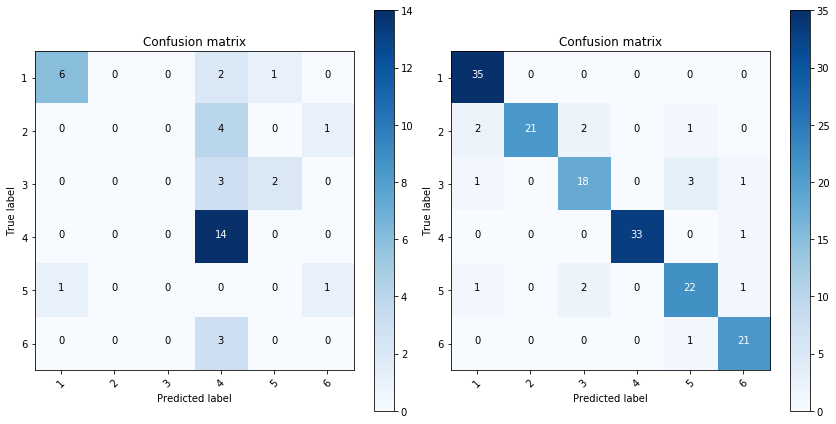

CPU times: user 2.14 s, sys: 649 ms, total: 2.78 s
Wall time: 1.57 s


In [60]:
%%time

def KK(N):
    print("KK neighbors model")
    
    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    # Create the classifier using the scikit learn library
    clf = KNeighborsClassifier(n_neighbors=1)
    
    #Train the classifier
    clf.fit(train_x, train_y)
    
    #New set of values
    test_x_photos, test_y_photos = read_test()
      
    #Predict the results of the test dataset
    predicted = clf.predict(test_x)
    predicted_photos = clf.predict(test_x_photos)
    print("The accuracy is: " + str(accuracy_score(test_y, predicted)))
    print("The accuracy is: " + str(accuracy_score(test_y_photos, predicted_photos)))
    
    #Plot confusion matrix for analyse the classification
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plot_confusion_matrix(clf, test_x_photos, test_y_photos)
   
    plt.subplot(122)
    plot_confusion_matrix(clf, test_x, test_y)
    plt.show()
    
KK(1000)

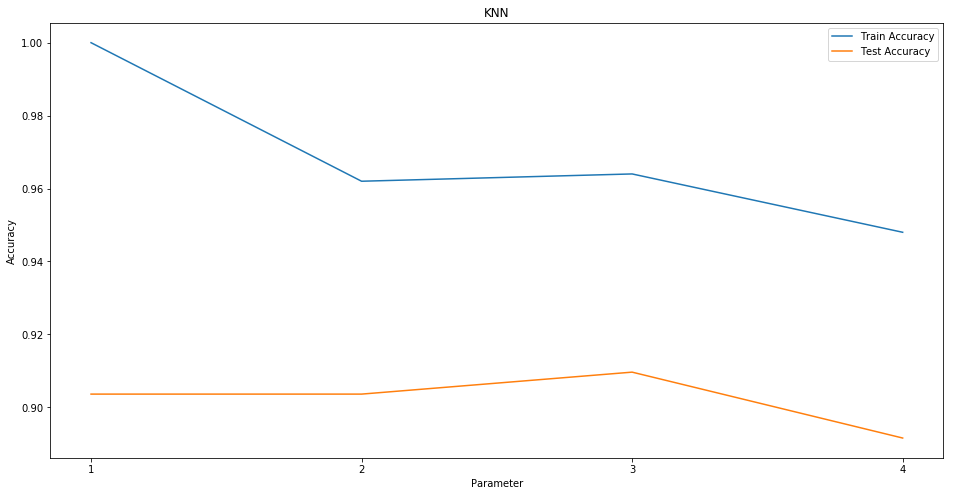

In [61]:
tuning_parameter(1, 5, 1000, 1)

## **Decision Tree**

Decision Tree model
The accuracy is: 0.850540216086
The accuracy is: 0.447368421053


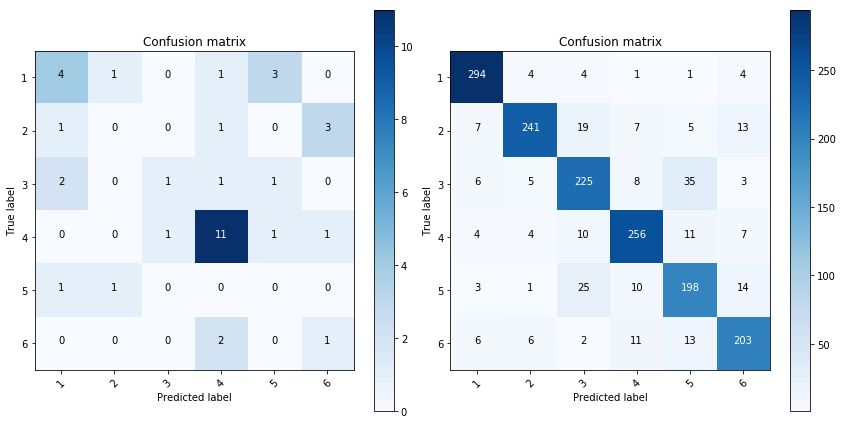

CPU times: user 4.76 s, sys: 726 ms, total: 5.49 s
Wall time: 4.36 s


In [62]:
%%time

from sklearn.tree import DecisionTreeClassifier

def DecisionTree(N):
    print("Decision Tree model")
    
    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    # Create the classifier using the scikit learn library
    clf = DecisionTreeClassifier(random_state = 0, max_depth = 15)
    
    #Train the classifier
    clf.fit(train_x, train_y)
    
    #New set of values
    test_x_photos, test_y_photos = read_test()
      
    #Predict the results of the test dataset
    predicted = clf.predict(test_x)
    predicted_photos = clf.predict(test_x_photos)
    print("The accuracy is: " + str(accuracy_score(test_y, predicted)))
    print("The accuracy is: " + str(accuracy_score(test_y_photos, predicted_photos)))
    
    #Plot confusion matrix for analyse the classification
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plot_confusion_matrix(clf, test_x_photos, test_y_photos)
   
    plt.subplot(122)
    plot_confusion_matrix(clf, test_x, test_y)
    plt.show()
    
    
DecisionTree(10000)


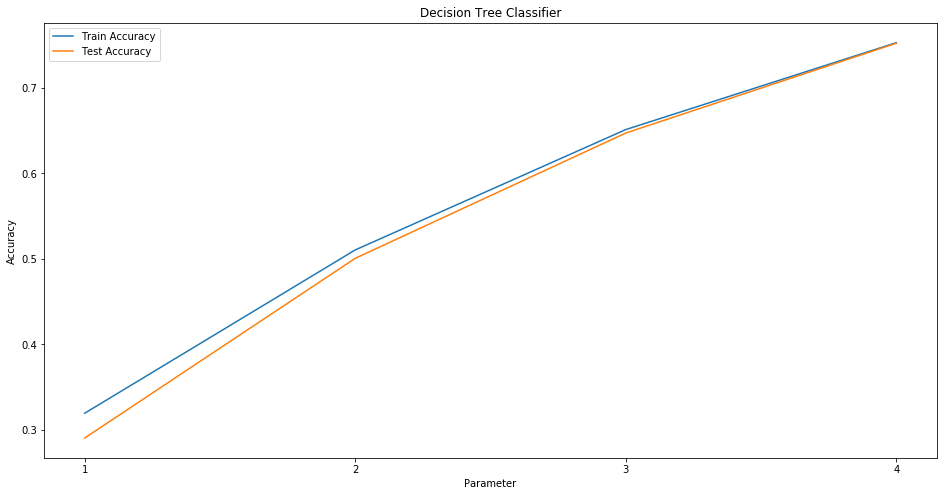

In [63]:
tuning_parameter(1, 5, 10000, 2)

## **Random Forest**

Random Forest model
The accuracy is: 0.921686746988
The accuracy is: 0.526315789474


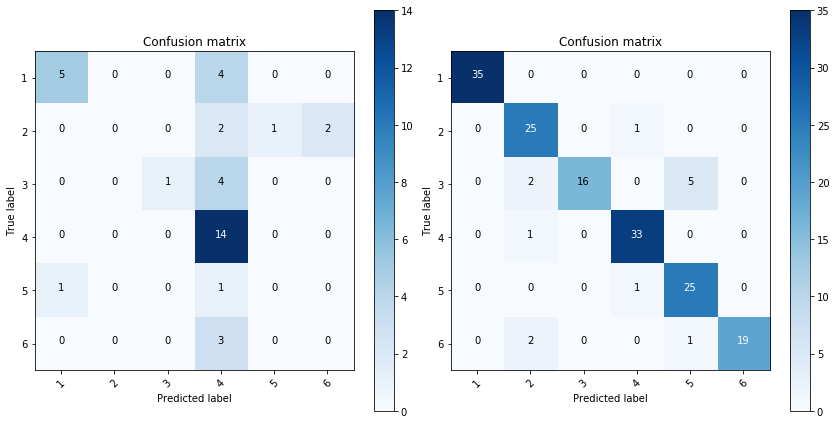

CPU times: user 1.69 s, sys: 589 ms, total: 2.28 s
Wall time: 1.33 s


In [64]:
%%time

from sklearn.ensemble import RandomForestClassifier

def RandomForest(N):
    print("Random Forest model")
    
    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    
    # Create the classifier using the scikit learn library
    clf = RandomForestClassifier(n_estimators=100)
    
    #Train the classifier
    clf.fit(train_x, train_y)
    
    #New set of values
    test_x_photos, test_y_photos = read_test()
      
    #Predict the results of the test dataset
    predicted = clf.predict(test_x)
    predicted_photos = clf.predict(test_x_photos)
    print("The accuracy is: " + str(accuracy_score(test_y, predicted)))
    print("The accuracy is: " + str(accuracy_score(test_y_photos, predicted_photos)))
    
    #Plot confusion matrix for analyse the classification
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plot_confusion_matrix(clf, test_x_photos, test_y_photos)
   
    plt.subplot(122)
    plot_confusion_matrix(clf, test_x, test_y)
    plt.show()
    
RandomForest(1000)


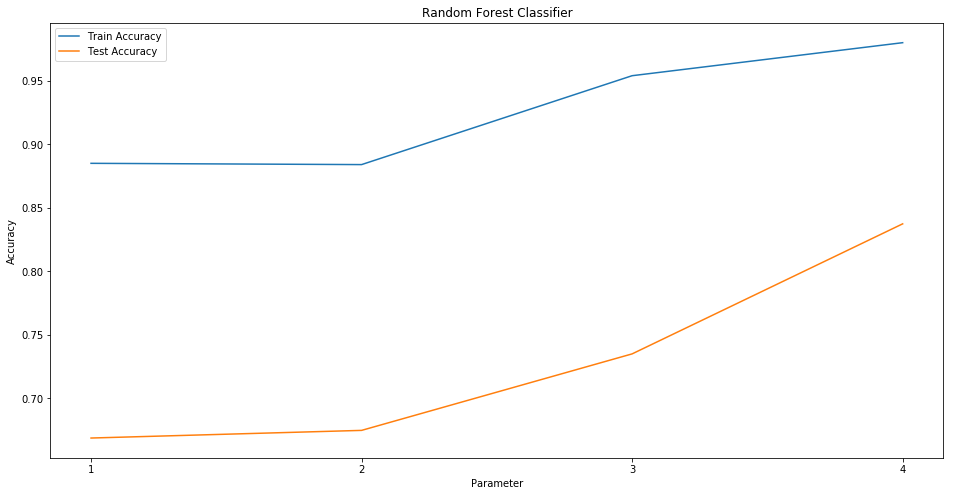

In [65]:
tuning_parameter(1, 5, 1000, 3)

## **Support Vector Machine**

Random Forest model
The accuracy is: 0.951807228916
The accuracy is: 0.526315789474


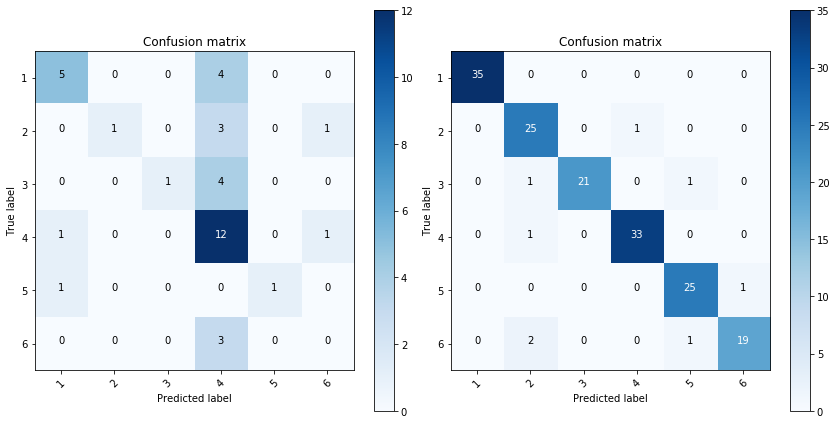

CPU times: user 2.26 s, sys: 661 ms, total: 2.92 s
Wall time: 1.63 s


In [69]:
%%time

from sklearn import svm

def SupportVectorMachine(N):
    print("Support Vector Machine model")
    
    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    
    # Create the classifier using the scikit learn library
    clf = svm.LinearSVC(random_state=0)
    
    #Train the classifier
    clf.fit(train_x, train_y)
    
    #New set of values
    test_x_photos, test_y_photos = read_test()
      
    #Predict the results of the test dataset
    predicted = clf.predict(test_x)
    predicted_photos = clf.predict(test_x_photos)
    print("The accuracy is: " + str(accuracy_score(test_y, predicted)))
    print("The accuracy is: " + str(accuracy_score(test_y_photos, predicted_photos)))
    
    #Plot confusion matrix for analyse the classification
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plot_confusion_matrix(clf, test_x_photos, test_y_photos)
   
    plt.subplot(122)
    plot_confusion_matrix(clf, test_x, test_y)
    plt.show()
    
RandomForest(1000)


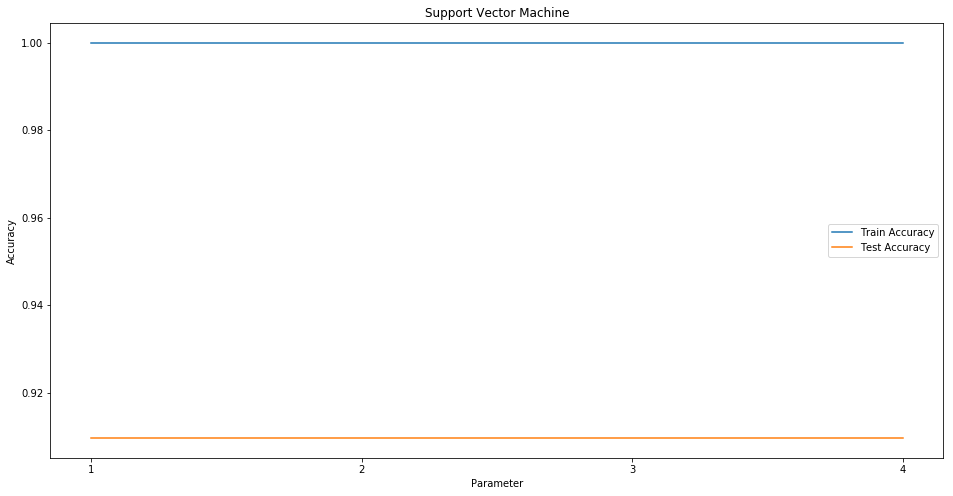

In [70]:
tuning_parameter(1, 5, 1000, 4)